In [ ]:
#| default_exp protocol

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
import networkx as nx
from simpleeval import simple_eval
from functools import cached_property
import matplotlib.pyplot as plt

from qsample.circuit import Circuit,unpack

In [ ]:
#| export
def draw_protocol(protocol, path=None, legend=False, figsize=(6,6), label_offset=(0.05,0.05)):
    """Draw protocol using `networkx` library
    
    Parameters
    ----------
    protocol : Protocol
        The protocol to draw
    path : str or None
        The path to save the resulting image to (optional)
    legend : bool
        If true, edge labels will be numbers referenced in legend
    figsize : tuple
        The `matplotlib` figsize argument of the plot
    label_offset : tuple
        Offset position of all edge labels
    """
    
    plt.figure(figsize=figsize)

    pos = nx.kamada_kawai_layout(protocol)
    size = max([len(n)**2 * 100 for n in pos.keys()])
    col = ['#ff0000' if not protocol.out_edges(n) else '#0080ff' if not protocol.in_edges(n) else 'black' for n in protocol.nodes]
    nx.draw(protocol, pos=pos, with_labels=True, node_color='white', node_size=size, edgecolors=col)

    edge_lbls = nx.get_edge_attributes(protocol, 'check')
    if legend:
        import matplotlib.lines as mlines
        n_edge_lbls, legend_lbls = dict(), []
        edge_cnt = 0
        for (to,fr),lbl in edge_lbls.items():
            if lbl == 'True': n_edge_lbls[(to,fr)] = lbl
            else: 
                edge_cnt += 1
                n_edge_lbls[(to,fr)] = f"${edge_cnt}$"
                leg_lbl = mlines.Line2D([], [], color='black', marker=f'${edge_cnt}$', linestyle='None', markersize=8, label=lbl)
                legend_lbls.append(leg_lbl)
        lgd = plt.legend(handles=legend_lbls, bbox_to_anchor=(1.04, 1), loc="upper left")
        edge_lbls = n_edge_lbls

    dx, dy = label_offset
    loop_pos = {n:(x+dx, y+dy) for n,(x,y) in pos.items()}
    loop_lbls = {(to,fr): lbl for (to,fr), lbl in edge_lbls.items() if to==fr}
    lbls = {(to,fr): lbl for (to,fr), lbl in edge_lbls.items() if to!=fr}
    edge_box = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    nx.draw_networkx_edge_labels(protocol, pos, lbls, font_size=12, bbox=edge_box, rotate=False if legend else True)
    nx.draw_networkx_edge_labels(protocol, loop_pos, loop_lbls, font_size=12, bbox=edge_box, rotate=True)

    if path and legend: plt.savefig(save_path, bbox_extra_artists=(lgd,), bbox_inches='tight')
    elif path: plt.savefig(path, bbox_inches='tight')

In [ ]:
#| export
class Protocol(nx.DiGraph):
    """Representation of a Quantum (Error Correction) Protocol
    
    Attributes
    ----------
    ft_level : int
        Degree of fault tolerance. `ft_level` corresponds to the total subset weight
        of a circuit path which, when less than `ft_level` always lead to deterministic result
    check_functions : dict
        Functions used in transition checks between circuits
    circuits : dict
        Circuits used inside protocol, key: circuit id
    qubits : set
        All qubits "touched" by the circuits
    root : str
        Start node of the protocol
    """
    
    def __init__(self, ft_level=0, check_functions={}, *args, **kwargs):
        """
        Parameters
        ----------
        ft_level : int
            Degree of protocol fault tolerance
        check_functions : dict
            Functions used in transition checks between circuits
        *args, **kwargs
            Any arguments passed to parent class `DiGraph`
        """
        super().__init__(*args, **kwargs)
        self.ft_level = ft_level
        self.check_functions = check_functions
        self.circuits = dict()

    @cached_property
    def qubits(self):
        return set(qb for c in self.circuits.values() for qb in unpack(c))
    
    @cached_property
    def root(self):
        deg_0_nodes = [n for n,d in self.in_degree if d==0]
        assert(len(deg_0_nodes)==1), "Protocol can only start with one node of degree 0."
        return deg_0_nodes[0]
    
    def get_circuit(self, name):
        """Return circuit corresponding to node `name`
        
        Parameters
        ----------
        name : str
            Name of node
        
        Returns
        -------
        Circuit
            Circuit corresponding to `name`
        """
        return self.circuits.get(self.nodes(data='circuit_id')[name], None)
    
    def add_node(self, name, circuit=None):
        """Add node to protocol
        
        Parameters
        ----------
        name : str
            Name of the node (must be unique)
        circuit : Circuit
            Circuit associated with node
        """
        assert(name not in self.nodes), f"Node name {name} not unique"

        if circuit:
            self.circuits[circuit.id] = circuit
            circuit_id = circuit.id
        else:
            circuit_id = None
            
        super().add_node(name, circuit_id=circuit_id)
        
    def add_nodes_from(self, names, circuits):
        """Add list of nodes and corresponding circuits to protocol
        
        Parameters
        ----------
        names : list of str
            Names of nodes (must be unique)
        circuits : list of Circuit or Circuit
            Circuits corresponding to names
        """
        if not isinstance(circuits, (list,tuple,set)):
            circuits = [circuits] * len(names)
        for name, circuit in zip(names, circuits):
            self.add_node(name, circuit)
        
    def successor(self, name, hist={}):
        """Return successor node of node `name`
        
        Parameters
        ----------
        name : str
            Name of node of which the successor is determined
        hist : dict
            Meaurement history used to determine successor via transition checks
            
        Returns
        -------
        tuple
            (name of successor node or None, corresponding circuit or None)
        """
        assert(name in self.nodes), f"Node {name} not in protocol"
        checks = {pair[1]: simple_eval(self.edges[pair]['check'], 
                                       names=lambda n: hist.get(n.id, None), 
                                       functions=self.check_functions) 
                  for pair in self.out_edges(name)}
        next_nodes = [(n,check) for n,check in checks.items() if check]
        assert(len(next_nodes) <= 1), f"Too many checks True for for node {name}"
        if len(next_nodes) == 0:
            # No checks True: End protocol
            return None, None
        else:
            succ_name, check_return = next_nodes[0]
            if self.out_degree(succ_name) == 0:
                # Terminal node reached: End protocol
                return succ_name, None
            if isinstance(check_return, Circuit):
                # Correction node: We only allow noise-free correction.
                return succ_name, check_return
            return succ_name, self.get_circuit(succ_name)
        
    def draw(self, *args, **kwargs):
        """Draw protocol"""
        return draw_protocol(self, *args, **kwargs)

In [ ]:
from qsample.examples import ghz1
assert(ghz1.successor('START', {})[0] == 'ghz')
assert(ghz1.successor('ghz', {'ghz': [1]})[0] == 'FAIL')
ghz1.successor('ghz', {'ghz': [1]})

('FAIL', None)

In [ ]:
from qsample.examples import ghz3
assert(ghz3.successor('START', {})[0] == 'ghz')
assert(ghz3.successor('ghz', {'ghz': [1]})[0] == 'ghz')
assert(ghz3.successor('ghz', {'ghz': [1,1,1]})[0] == 'FAIL')

['X1b', 'nonFT']

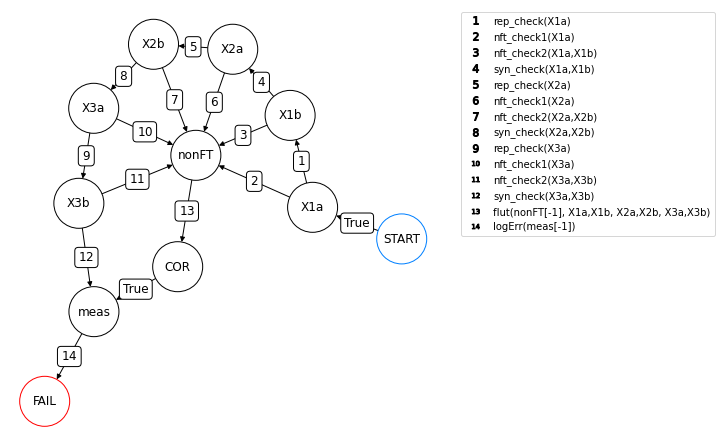

In [ ]:
# ghz3.get_circuit('FAIL')
# ghz3.draw()

from qsample.examples import flagstab
flagstab.draw(legend=True)

[n for n in flagstab.neighbors('X1a')]